# La Reponctuation du chinois ancien: modèle d'étiquetage
Ce notebook détaille la reponctuation du chinois ancien comme une tâche d’étiquetage de séquence: Chaque caractère du texte brut (sans ponctuation) est traité comme une unité à laquelle le modèle doit associer une étiquette qui indique la présence ou non d’un signe de ponctuation particulier à cet endroit.

### Entrées du modèle
Séquence de caractères chinois (texte sans ponctuation), longueur variable (ici tronquée/paddée à MAXLEN). Chaque caractère est converti en entier via un dictionnaire de vocabulaire (tokenisation caractère).

### Sorties attendues
Pour chaque caractère en entrée, le modèle doit prédire une étiquette parmi un ensemble pré-défini de tags (TAGS) :
- "O" (pas de ponctuation)
- "COMMA" (virgule)
- "PERIOD" (point)
- "COLON", "SEMICOLON", "QUES" (interrogation), "EXCL" (exclamation), etc.

Ce que l'on attend : une séquence d’étiquettes (une par caractère) de même longueur que l’entrée (paddée si besoin).

### Exemple:
- Texte avec ponctuation: `徐知證義袓第五子也。事吳歷州刺史，至節度使。`
- Texte d'entrée (sans ponctuation): `徐知證義袓第五子也事吳歷州刺史至節度使`
- Sortie attendue (étiquettes par caractère) : `O O O O O O O O O PERIOD O O O O O O O O O O PERIOD`

In [17]:

import os
import tensorflow as tf
import keras
import numpy as np, glob, random, re, shutil
from sklearn.metrics import f1_score
from collections import Counter
from matplotlib import pyplot as plt


In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

# chemins
DATA_DIR = "./dataset"
TRAIN_DIR = f"{DATA_DIR}/train"
DEV_DIR   = f"{DATA_DIR}/dev"
TEST_RAW  = f"{DATA_DIR}/test"       # sans ponctuation
TEST_GOLD = f"{DATA_DIR}/test_gold"  # avec ponctuation

# si pas de dev，tirer 10% depuis train
if not os.path.exists(DEV_DIR) or not os.listdir(DEV_DIR):
    os.makedirs(DEV_DIR, exist_ok=True)
    files = sorted(glob.glob(f"{TRAIN_DIR}/*.txt"))
    random.shuffle(files)
    for p in files[: int(0.1*len(files))]:
        shutil.move(p, f"{DEV_DIR}/{os.path.basename(p)}")


In [ ]:
# ─── 2. ETIQUETTES DES PONCTUATIONS ───────────────────────────────────────────
TAGS = ["O","COMMA","ENUM_COMMA","PERIOD","COLON","SEMICOLON",
        "QUES","EXCL","LQUO","RQUO","PAD"]
tag2id = {t:i for i,t in enumerate(TAGS)}
id2tag = {i:t for t,i in tag2id.items()}

PUNCT2TAG = {"，":"COMMA","、":"ENUM_COMMA","。":"PERIOD",
             "：":"COLON","；":"SEMICOLON","？":"QUES","！":"EXCL",
             "「":"LQUO","」":"RQUO"}

def make_example(text:str):
    chs, labs = [], []
    i = 0
    while i < len(text):
        ch = text[i]
        if ch in PUNCT2TAG:
            if labs: labs[-1] = PUNCT2TAG[ch]
            i += 1
        else:
            chs.append(ch); labs.append("O"); i += 1
    return chs, labs

def load_folder(folder, with_label=True):
    X, Y = [], []
    for fp in sorted(glob.glob(f"{folder}/*.txt")):
        txt = open(fp, encoding="utf-8").read().strip()
        if with_label: chs,lbs = make_example(txt)
        else:          chs,lbs = list(txt), ["O"]*len(txt)
        X.append(chs); Y.append(lbs)
    return X, Y

train_X, train_Y = load_folder(TRAIN_DIR, True)
dev_X,   dev_Y   = load_folder(DEV_DIR,   True)
test_X,  _       = load_folder(TEST_RAW,  False)
_,       gold_Y  = load_folder(TEST_GOLD, True)


In [ ]:
# ─── 3. DICT + ENCODAGE ────────────────────────────────────────
PAD_ID, UNK_ID = 0,1
vocab = {"<PAD>":PAD_ID,"<UNK>":UNK_ID}
for seq in train_X:
    for ch in seq:
        if ch not in vocab: vocab[ch] = len(vocab)

def encode(seq, maxlen=256):
    ids = [vocab.get(c, UNK_ID) for c in seq][:maxlen]
    mask= [1]*len(ids)
    ids += [PAD_ID]*(maxlen-len(ids))
    mask+= [0]*(maxlen-len(mask))
    return ids, mask

def encode_dataset(X,Y,maxlen=256):
    xs,ys,ms = [],[],[]
    for chs,lbs in zip(X,Y):
        xi,mi = encode(chs,maxlen)
        yi = [tag2id[t] for t in lbs[:maxlen]] + [tag2id["PAD"]]*(maxlen-len(lbs))
        xs.append(xi); ys.append(yi); ms.append(mi)
    return np.array(xs),np.array(ys),np.array(ms,bool)

MAXLEN = 256
x_tr,y_tr,m_tr = encode_dataset(train_X,train_Y,MAXLEN)
x_dev,y_dev,m_dev = encode_dataset(dev_X,dev_Y,MAXLEN)
x_te,_,_ = encode_dataset(test_X,gold_Y,MAXLEN)

# fréquence des des étiquettes
label_counter = Counter(t for seq in train_Y for t in seq if t != "PAD")
total_tokens  = sum(label_counter.values())
num_classes   = len(TAGS)

# formule = total / (num_classes * freq)
class_weight = { tag2id[tag]: total_tokens / (num_classes * freq)
                 for tag, freq in label_counter.items() }


### Architecture du modèle
- L’entrée du modèle est une séquence de caractères converti en un vecteur. Il passe ensuite dans une couche **LSTM bidirectionnelle**, qui permet au modèle de prendre en compte à la fois le contexte gauche et le contexte droit autour de chaque caractère. 
- La sortie du BiLSTM, pour chaque caractère, est un vecteur qui encode ce contexte. (Un dropout est appliqué pour régulariser le modèle) suivi d’une couche dense intermédiaire (activation ReLU) qui réduit la dimension. 
- Enfin, une couche dense avec softmax produit, pour chaque caractère de la séquence, une distribution de probabilité sur les 11 étiquettes possibles (différents types de ponctuation + “O” pour absence de ponctuation).

In [ ]:
# ─── 4. modèle ─────────────────────────────────────────────
EMB, HID = 256, 256
N_LABELS = len(TAGS)

inputs = keras.Input((MAXLEN,))
x      = keras.layers.Embedding(len(vocab), EMB, mask_zero=True)(inputs)
x      = keras.layers.Bidirectional(
           keras.layers.LSTM(HID, return_sequences=True))(x)
x      = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(N_LABELS, activation="softmax")(x)   # ← 唯一输出层

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 256, 256)          1221120   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 512)         1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256, 512)          0         
                                                                 
 dense_2 (Dense)             (None, 256, 100)          51300     
                                                                 
 dropout_3 (Dropout)         (None, 256, 100)          0         
                                                           

In [ ]:
# ── 4.5 sample_weight (mask × class_weight) ────────────
freq = Counter(t for seq in train_Y for t in seq)

#  Calculer les poids pour chaque étiquette
max_f = max(freq.values())
weight_vec = np.ones(len(TAGS), dtype="float32")
for tag, f in freq.items():
    if tag == "PAD":        # PAD 一律 0，完全不计入 loss
        weight_vec[tag2id[tag]] = 0.0
    else:
        weight_vec[tag2id[tag]] = np.sqrt(max_f / f)

#  Calculer les poids pour chaque échantillon
sw_tr  = weight_vec[y_tr] * m_tr
sw_dev = weight_vec[y_dev] * m_dev


## Tuning des hyperparamètres du modèle
Nous avons intégré une étape de tuning automatisée via KerasTuner afin d’optimiser plusieurs paramètres importants.

### Hyperparamètres testés
- Taille des embeddings (`emb_dim`) : dimension des vecteurs de caractères (entre 64 et 512)
- Dimension de la couche LSTM (`lstm_dim`) : nombre d’unités dans la BiLSTM (entre 64 et 512)
- Taille de la couche dense (`dense_dim`) : nombre de neurones dans la couche dense intermédiaire (entre 32 et 256)
- Taux de dropout (`dropout1` et `dropout2`) : régularisation après la LSTM et la couche dense (de 0.1 à 0.5)
- Taux d’apprentissage (`lr`) : valeur initiale du learning rate de l’optimiseur Adam (entre 1e-4 et 5e-3, échelle log)

In [ ]:
import keras_tuner as kt

def build_model(hp):
    inputs = keras.Input((MAXLEN,))
    x = keras.layers.Embedding(
        len(vocab),
        hp.Int("emb_dim", min_value=64, max_value=512, step=64, default=256),
        mask_zero=True
    )(inputs)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            hp.Int("lstm_dim", min_value=64, max_value=512, step=64, default=256),
            return_sequences=True
        )
    )(x)
    x = keras.layers.Dropout(hp.Float("dropout1", 0.1, 0.5, step=0.1, default=0.3))(x)
    x = keras.layers.Dense(
        hp.Int("dense_dim", min_value=32, max_value=256, step=32, default=100),
        activation="relu"
    )(x)
    x = keras.layers.Dropout(hp.Float("dropout2", 0.1, 0.5, step=0.1, default=0.3))(x)
    outputs = keras.layers.Dense(N_LABELS, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("lr", 1e-4, 5e-3, sampling="log", default=1e-3)
        ),
        loss="sparse_categorical_crossentropy",
        weighted_metrics=["sparse_categorical_accuracy"], 
        metrics=["accuracy"],
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective="val_sparse_categorical_accuracy",
    max_epochs=10,
    factor=3,
    directory="kt_dir",
    project_name="punctuation"
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    x_tr, y_tr,
    sample_weight=sw_tr,
    validation_data=(x_dev, y_dev, sw_dev),
    batch_size=32,
    callbacks=[stop_early],
    verbose=2
)

# Récupérer le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)


In [23]:
# ─── 5. ENTRAINEMENT ────────────────────────────────
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["sparse_categorical_accuracy"], 
    metrics=["accuracy"],
)


history = model.fit(
    x_tr, y_tr, sample_weight=sw_tr,
    validation_data=(x_dev, y_dev, sw_dev),
    batch_size=32, epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=2
)


Epoch 1/30


2025-05-30 20:37:02.037376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2025-05-30 20:37:11.038206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


3/3 - 29s - loss: 3.8977 - accuracy: 0.4783 - sparse_categorical_accuracy: 0.3189 - val_loss: 3.9129 - val_accuracy: 0.8149 - val_sparse_categorical_accuracy: 0.4784 - 29s/epoch - 10s/step
Epoch 2/30
3/3 - 4s - loss: 3.6089 - accuracy: 0.8181 - sparse_categorical_accuracy: 0.4998 - val_loss: 5.1311 - val_accuracy: 0.8149 - val_sparse_categorical_accuracy: 0.4784 - 4s/epoch - 1s/step
Epoch 3/30
3/3 - 4s - loss: 3.6603 - accuracy: 0.8181 - sparse_categorical_accuracy: 0.4998 - val_loss: 3.3428 - val_accuracy: 0.8149 - val_sparse_categorical_accuracy: 0.4784 - 4s/epoch - 1s/step
Epoch 4/30
3/3 - 3s - loss: 3.1810 - accuracy: 0.8181 - sparse_categorical_accuracy: 0.4998 - val_loss: 3.2994 - val_accuracy: 0.8149 - val_sparse_categorical_accuracy: 0.4784 - 3s/epoch - 1s/step
Epoch 5/30
3/3 - 3s - loss: 3.0600 - accuracy: 0.8177 - sparse_categorical_accuracy: 0.4998 - val_loss: 2.9721 - val_accuracy: 0.8149 - val_sparse_categorical_accuracy: 0.4784 - 3s/epoch - 1s/step
Epoch 6/30
3/3 - 4s - l

### Commentaires
- L’accuracy d’entraînement et de validation monte progressivement de ~0.48 à ~0.67 (train) et ~0.65 (val) sur 30 époques, sans surapprentissage flagrant.
- La validation reste longtemps stable autour de 0.48, puis décolle après l’époque 12–13. Cela indique que le modèle a eu besoin de plusieurs itérations (probablement à cause du déséquilibre de classes, la majorité des caractères sont étiquetés "O").
- L’écart entre train/val reste faible : il n’y a pas de surapprentissage sévère, mais le modèle pourrait probablement encore progresser avec plus de données, des augmentations ou une pondération optimisée.

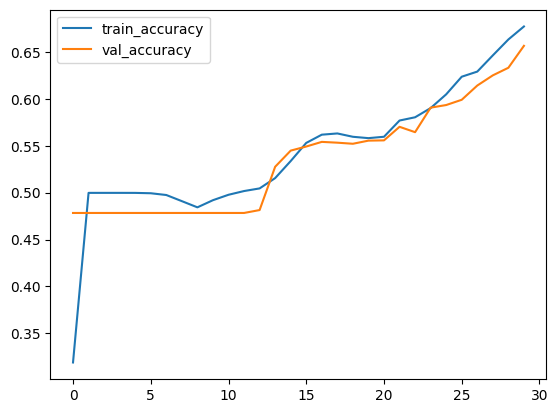

In [24]:
plt.plot(history.history["sparse_categorical_accuracy"], label="train_accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

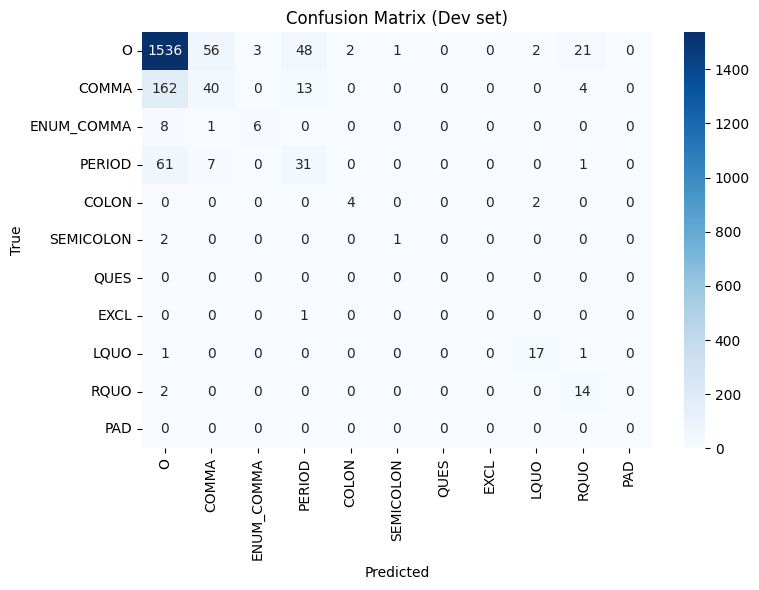

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# prdiction sur le dev 
proba_dev = model.predict(x_dev, batch_size=32, verbose=0)
pred_dev  = proba_dev.argmax(-1)

# ② flatten -> 1-D，garder PAD 
y_true_flat, y_pred_flat = [], []
for t, p, m in zip(y_dev, pred_dev, m_dev):
    valid = m.astype(bool)
    y_true_flat.extend(t[valid])
    y_pred_flat.extend(p[valid])

# visualisation confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat,
                      labels=list(range(len(TAGS))))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TAGS, yticklabels=TAGS)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Dev set)')
plt.tight_layout()
plt.show()

## Analyse des résultats:
L’essentiel du volume est concentré sur la diagonale pour "O" : le modèle détecte bien l’absence de ponctuation. 
- Il y a cependant beaucoup de confusion entre “O” et les ponctuations principales (surtout “COMMA” et “PERIOD”). 
- "COMMA"/"PERIOD" : Plusieurs cas mal classés comme "O", la détection reste difficile 
- Les signes rares (COLON, SEMICOLON, QUES, EXCL) sont très peu détectés ou souvent confondus avec "O" ou d’autres tags plus fréquents.
- Les guillemets (LQUO, RQUO) sont parfois prédits, mais il y a encore de la confusion. Ponctuations rares sont presque jamais prédites, ou alors confondues.




Le modèle atteint une accuracy globale d’environ 66% sur le dev set, mais cette moyenne masque un fort déséquilibre : il prédit très bien l’absence de ponctuation, mais détecte moins bien les vrais signes de ponctuation, surtout les plus rares. La matrice de confusion montre que la plupart des erreurs sont des confusions avec la classe "O". Ce résultat est attendu pour une première approche sur ce type de corpus très déséquilibré. 

## Axes d’amélioration
- Renforcer la pondération des classes rares 
- Data augmentation (collecter plus d’exemples avec des ponctuations rares)
- Tester un CRF en sortie pour forcer une cohérence séquentielle